# 2 - Vertex AI - AutoML with clients (code)

 This builds a custom model with AutoML and deploys it to an Endpoint for predictions and explanations. 


### Prerequisites:
-  01 - BigQuery - Table Data Source

### Overview:
-  Use Python client google.cloud.aiplatform for Vertex AI
   -  Create a dataset
      -  aiplatform.TabularDataset
      -  Link BigQuery table
   -  Train Model with AutoML
      -  aiplatform.AutoMLTabularTrainingJob
   -  Evaluate
      -  Review the model in GCP Console > Vertex AI > Models
   -  Deploy to Endpoint
      -  Endpoint = aiplatform.Endpoint
      -  Endpoint.deploy
   -  Online Predictions
      -  Endpoint.predict
   -  Explanations
      -  Endpoint.explain
   -  Batch Prediction Job
      -  aiplatform.BatchPredictionJob

### Resources:
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  [AutoML Tabular Training Job With Python Client](https://cloud.google.com/vertex-ai/docs/training/automl-api#aiplatform_create_training_pipeline_tabular_classification_sample-python)
-  [Interpreting Explanations](https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular)


---
## Setup

inputs:

In [1]:
REGION = 'us-central1'
PROJECT_ID='qwiklabs-gcp-04-24efb7132888'
DATANAME = 'fraud'
NOTEBOOK = '2'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [2]:
from google.cloud import aiplatform
from datetime import datetime

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [3]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [4]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
DIR = f"temp/{NOTEBOOK}"

environment:

In [5]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Create Dataset (link to BigQuery table)

In [6]:
dataset = aiplatform.TabularDataset.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.datasets.dataset:Creating TabularDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create TabularDataset backing LRO: projects/948421954571/locations/us-central1/datasets/1407291320669569024/operations/8808157482263248896
INFO:google.cloud.aiplatform.datasets.dataset:TabularDataset created. Resource name: projects/948421954571/locations/us-central1/datasets/1407291320669569024
INFO:google.cloud.aiplatform.datasets.dataset:To use this TabularDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.TabularDataset('projects/948421954571/locations/us-central1/datasets/1407291320669569024')


---
## Train Model with AutoML

In [7]:
column_specs = list(set(dataset.column_names) - set(VAR_OMIT.split()) - set([VAR_TARGET, 'splits']))

In [8]:
column_specs = dict.fromkeys(column_specs, 'auto')

Define a Job:
- Consider Weighting
- Model Type
- Optimization Objective

https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLTabularTrainingJob

In [9]:
tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    optimization_prediction_type = 'classification',
    optimization_objective = 'maximize-au-prc',
    column_specs = column_specs,
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [10]:
model = tabular_classification_job.run(
    dataset = dataset,
    target_column = VAR_TARGET,
    predefined_split_column_name = 'splits',
    #    training_fraction_split = 0.8,
    #    validation_fraction_split = 0.1,
    #    test_fraction_split = 0.1,
    budget_milli_node_hours = 1000,
    model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    disable_early_stopping = False,
    model_labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5598687370112139264?project=948421954571
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/948421954571/locations/us-central1/trainingPipelines/5598687370112139264 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/948421954571/locations/us-central1/trainingPipelines/5598687370112139264 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/948421954571/locations/us-central1/trainingPipelines/5598687370112139264 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:AutoMLTabularTrainingJob projects/948421954571/locations/us-central1/trainingPipelines/5598687370112139264 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud

---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.


Setup a model client for the model create by this notebook:

In [11]:
model.resource_name

'projects/948421954571/locations/us-central1/models/6848026698626105344'

In [12]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

Retrives the aggregate model evalution metrics for the model as a whole.  First, use `.list_model_evaluations` to retrieve the evaluation id, then use `.get_model_evaluation` for the evaluation id:

In [13]:
evaluations = model_client.list_model_evaluations(parent = model.resource_name)
evals = iter(evaluations)
eval_id = next(evals).name
geteval = model_client.get_model_evaluation(name = eval_id)

Review several of the metrics include in the evaluation.  Also, compare these to the results in the console view.

In [14]:
geteval.metrics['auPrc']

0.9994493

In [15]:
for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [28567.0, 0.0]
True Label =  1  has Predicted labels =  [18.0, 40.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model:

In [16]:
slices = model_client.list_model_evaluation_slices(parent = eval_id)

In [17]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  1 has auPrc =  0.77886915
Label =  0 has auPrc =  0.9995786


---
## Endpoint and Deployment

In [18]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/948421954571/locations/us-central1/endpoints/8293000481802813440/operations/4074311323943436288
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/948421954571/locations/us-central1/endpoints/8293000481802813440
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/948421954571/locations/us-central1/endpoints/8293000481802813440')


In [19]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

INFO:google.cloud.aiplatform.models:Deploying Model projects/948421954571/locations/us-central1/models/6848026698626105344 to Endpoint : projects/948421954571/locations/us-central1/endpoints/8293000481802813440
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/948421954571/locations/us-central1/endpoints/8293000481802813440/operations/975834780312535040
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/948421954571/locations/us-central1/endpoints/8293000481802813440


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [20]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [21]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,108552,-0.800747,1.185243,-1.307864,-1.021146,-0.501487,-0.280646,-1.055654,0.994632,2.277438,...,0.244974,0.081168,-1.856601,-1.159921,-0.300115,0.172426,0.0,0,683f3632-4d23-46b1-bc28-bdea77438e0a,TEST
1,152933,1.899377,0.520212,-0.397464,3.492509,0.660067,0.902600,-0.126600,0.209196,-1.032307,...,0.509313,0.172632,-0.523424,-0.628977,-0.015943,-0.037275,0.0,0,9b621701-7e1d-44ee-b83f-0872c3feac62,TEST
2,169514,1.983349,-0.319376,-0.391078,0.287527,-0.449550,-0.166502,-0.592739,0.006890,0.962290,...,0.014298,-0.269116,0.023498,-0.142238,0.042028,-0.050875,0.0,0,7c673636-c18d-4c43-895a-eeadd92ef1ef,TEST
3,56774,1.282808,0.153264,0.111244,0.682014,-0.362113,-1.027642,0.192959,-0.227975,0.264107,...,-0.098736,0.442745,0.643293,0.556626,-0.056407,-0.000733,0.0,0,e5045737-d174-4678-a09a-4c66882fc1fa,TEST


In [22]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
#newob

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [23]:
newob['Time'] = str(newob['Time'])

In [24]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

### Get Predictions: Python Client

In [25]:
prediction = endpoint.predict(instances=instances, parameters=parameters)

In [26]:
prediction

Prediction(predictions=[{'classes': ['0', '1'], 'scores': [0.9999317526817322, 6.825515447417274e-05]}], deployed_model_id='7607943165047209984', explanations=None)

In [27]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [28]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [29]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

E0320 13:49:16.522700058   23376 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


{
  "predictions": [
    {
      "scores": [
        0.99993175268173218,
        6.8255154474172741e-05
      ],
      "classes": [
        "0",
        "1"
      ]
    }
  ],
  "deployedModelId": "7607943165047209984",
  "model": "projects/948421954571/locations/us-central1/models/6848026698626105344",
  "modelDisplayName": "2_fraud_20220320112444"
}


### Get Predictions: gcloud (CLI)

In [30]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

E0320 13:49:17.573960686   23376 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9999317526817322, 6.825515447417274e-05]}]


---
## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [31]:
explanation = endpoint.explain(instances=instances, parameters=parameters)

In [32]:
explanation.predictions

[{'classes': ['0', '1'],
  'scores': [0.9999317526817322, 6.825515447417274e-05]}]

In [33]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.9997568130493164
instance output 0.9999317526817322
output_index [0]
output display value 0
approximation error 0.016502518962756223


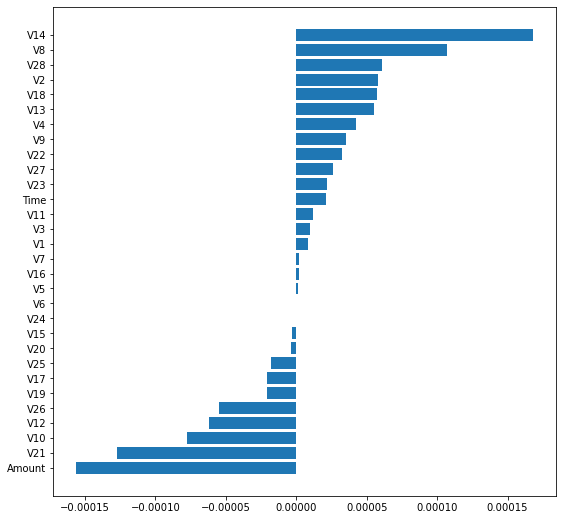

In [34]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [35]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    model_name = model.name,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation = True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/948421954571/locations/us-central1/batchPredictionJobs/5304827494426214400
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/948421954571/locations/us-central1/batchPredictionJobs/5304827494426214400')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/5304827494426214400?project=948421954571
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/948421954571/locations/us-central1/batchPredictionJobs/5304827494426214400 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/948421954571/locations/us-central1/batchPredictionJobs/5304827494426214400 current state:
JobState.JOB_STAT